# Exploratory Data Analysis (Time & Gambles)

We are going to be looking for patterns in players who only played in the month of June. This is with the purpose to distinguish players between short and long positions, and the reasons why they hold this positions. 

In [1]:
# import all necesary libraries for the project
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define working directory
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/1_Generic"
os.chdir(path)

# Filter Columns
filter = ['playerkey', 'playercashableamt', 'wageredamt', 'maxbet', 'grosswin',
       'currencyinamt', 'assetnumber', 'theoreticalpaybackpercent', 
       'age', 'rank', 'gender', 'date', 'start_time', 'end_time', 'duration',
       'slotdenomination']
# Import data
dtf = pd.read_parquet('month_6_year_2015.parquet', columns=filter)

# Check data
dtf.columns

# Select only the rows where duration is greater than or equal to zero
dtf = dtf[dtf['duration'] >= pd.Timedelta(0)]

In [3]:
# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

## Calculate Foundamental Variables

The following variables were calculated using existing data:
* _player_loss_: how much money each player has lost in each gamble.
* _player_wins_: equals the amount of money they bet plus how much they won.
* _percent_return_: the return in player's bets for each gamble played. 

$$\text{percent return} = (\frac{df[wins] - df[wageredamt]}{df[wageredamt]})*100$$

* _playercashableamt_pct_change_: calculates the rate of change of player's outstanding gambling amount. 

$$\text{playercashableamt \% change} = (\frac{df[playercashableamt_{t+1}] - df[playercashableamt_{t}]}{df[playercashableamt_{t}]})*100$$

In [4]:
# Crate a new colum that is the inverse of casino_grosswin, named "player_loss"
dtf['ops'] = dtf['grosswin']*-1

# Create a new column that is the inverse of casino_grosswin, named "player_loss" that includes all negative values of 'ops'
dtf['player_loss'] = np.where(dtf['ops'] < 0, dtf['ops'], 0)

# Create a new column that is the inverse of casino_grosswin, named "player_wins" that includes all positive values of 'ops'
dtf['player_wins'] = np.where(dtf['ops'] > 0, dtf['ops'], 0)

# Create total_amt_won column
dtf['total_amt_won'] = dtf["wageredamt"]+dtf["ops"]

# Create colum profit
dtf['profit'] = dtf['total_amt_won'] - dtf['wageredamt']

# # Calculate percentage return for each gamble and add it as a new column
dtf["percent_return"] = ((dtf["wageredamt"]+dtf["ops"]) - dtf["wageredamt"]) / dtf["wageredamt"] * 100

# # Create a time series variable for each player that starts at 1 and increases by 1 for each row
draw_condition = dtf['grosswin'] == 0

for i, row in dtf.iterrows():
    if draw_condition[i]:
        dtf.loc[i, 'profit'] = 0

# Drop 'ops' column
dtf = dtf.drop(columns=['ops'])

# Create a time series variable for each player that starts at 1 and increases by 1 for each row
dtf["gambles"] = dtf.groupby("playerkey").cumcount() + 1

### Calulates Number of Visits

In [5]:
# Group the DataFrame by playerkey
groups = dtf.groupby('playerkey')

# Initialize the visit column to 1 for the first visit of each player
dtf['visit'] = groups['date'].transform(lambda x: (x.diff().dt.days >= 1).cumsum() + 1)

# Reset the visit count for each new player
dtf['visit'] = dtf.groupby('playerkey')['visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate Sessions based on Time

If there is a pause of 30 minutes or more between gambles it is considered the end of a session, and the start of a new one.

In [6]:
# Convert the start_time column to datetime
dtf["start_time"] = pd.to_datetime(dtf["start_time"])

# Sort data by start_time and playerkey
dtf = dtf.sort_values(by=['playerkey', 'date', 'start_time'])

# Compute the time difference between consecutive gambles for each player
dtf['time_diff'] = dtf.groupby('playerkey')['start_time'].diff()

# Initialize the session_time column to 1 for the first gamble of each player
dtf['session_time'] = dtf.groupby('playerkey').ngroup() + 1

# Update the session_time column based on the time difference
dtf['session_time'] += (dtf['time_diff'] > pd.Timedelta(minutes=30)).cumsum()

# Reset the session_time count for each new visit
dtf['session_time'] = dtf.groupby(['playerkey', 'visit'])['session_time'].apply(lambda x: x - x.iloc[0] + 1)

# Remove the temporary time_diff column
dtf = dtf.drop('time_diff', axis=1)

### Calculate Sessions based on Machine Change

Everytime a player switches machine a new sessions begins.

In [7]:
# Initialize the session_machine column to 1 for the first machine of each player
dtf['session_machine'] = (dtf.groupby("playerkey")["assetnumber"].diff() != 0).cumsum()

# Reset the session_machine count for each new visit
dtf['session_machine'] = dtf.groupby(['playerkey', 'visit'])['session_machine'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Visit

In [8]:
# Create a column named "gambles_visit" that is the number of gambles per visit
dtf["gambles_visit"] = dtf.groupby(["playerkey", "visit"])["gambles"].cumcount() + 1

# Reset the gambles_visit count for each new visit
dtf['gambles_visit'] = dtf.groupby(['playerkey', 'visit'])['gambles_visit'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Time

In [9]:
# Create a column named "gambles_session" that is the number of gambles per session
dtf["gambles_session"] = dtf.groupby(["playerkey", "session_time"])["gambles"].cumcount() + 1

# Reset the gambles_session count for each new session
dtf['gambles_session'] = dtf.groupby(['playerkey', 'session_time'])['gambles_session'].apply(lambda x: x - x.iloc[0] + 1)


### Calculate the number of gambles per Session Machine

In [10]:
# Create a column named "gambles_machine" that is the number of gambles per session_machine
dtf["gambles_machine"] = dtf.groupby(["playerkey", "session_machine"])["gambles"].cumcount() + 1

# Reset the gambles_machine count for each new session_machine
dtf['gambles_machine'] = dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].apply(lambda x: x - x.iloc[0] + 1)

### Calculate the number of Machine Changes


In [11]:
# Create a column called change_machine that is 1 everytime a player changes assetnumber 0 otherwise, grouped by playerkey and session_time
dtf['machines_played'] = (dtf.groupby(['playerkey', 'session_time'])['assetnumber'].diff() != 0).astype(int)

## Frequencies of Gambles

### General

Let's see who plays the most, the least, and the min, max, average, and median number of gambles withouth making a distictions between visits, sessions per time or machine.

In [12]:
# Total number of players
print("Total number of players:", dtf["playerkey"].nunique())

# Total number of gambles
print("Total number of gambles:", dtf.groupby('playerkey')['gambles'].max().sum())

print("--------------------------------------------")
# What is the maximum number of periods played by each player?
print("Maximimum # of gambles of a single player:", dtf.groupby('playerkey')['gambles'].max().max())

#Who is the player with the maximum number of periods played?
print("Player who gambled the most:", dtf.groupby('playerkey')['gambles'].max().idxmax())

print("--------------------------------------------")

# What is the minimum number of periods played by each player?
print("Minimum # of gambles of a single player:", dtf.groupby('playerkey')['gambles'].max().min())

#Who is the player with the minimum number of periods played?
print("Player who gambled the least:", dtf.groupby('playerkey')['gambles'].max().idxmin())

print("--------------------------------------------")

# What is the median number of periods played by each player?
print("Median # of gambles of all players:", round(dtf.groupby('playerkey')['gambles'].max().median(), 2))

# How many players played at least 150 gambles?
print("Number of players who played exactly 150 times:", dtf.groupby('playerkey')['gambles'].max()[dtf.groupby('playerkey')['gambles'].max() == 150].count())
print("Number of players who gambled less than 150 times:", dtf.groupby('playerkey')['gambles'].max()[dtf.groupby('playerkey')['gambles'].max() < 150].count())
print("Number of players who gambled more than 150 times:", dtf.groupby('playerkey')['gambles'].max()[dtf.groupby('playerkey')['gambles'].max() > 150].count())
print("--------------------------------------------")

# Most common # of gambles per person
print("Most common # of gambles:", dtf.groupby('playerkey')['gambles'].max().mode().tolist())

# What is the average number of periods played by each player?
print("Average # of gambles of all players:", round(dtf.groupby('playerkey')['gambles'].max().mean(), 2))

# How many players played at least 278 gambles?
print("Number of players who gambled at least 278 times:", dtf.groupby('playerkey')['gambles'].max()[dtf.groupby('playerkey')['gambles'].max() >= 278].count())

Total number of players: 282
Total number of gambles: 78245
--------------------------------------------
Maximimum # of gambles of a single player: 3106
Player who gambled the most: 33
--------------------------------------------
Minimum # of gambles of a single player: 1
Player who gambled the least: 15
--------------------------------------------
Median # of gambles of all players: 150.0
Number of players who played exactly 150 times: 3
Number of players who gambled less than 150 times: 140
Number of players who gambled more than 150 times: 139
--------------------------------------------
Most common # of gambles: [2, 15]
Average # of gambles of all players: 277.46
Number of players who gambled at least 278 times: 87


#### Visits and Sessions

In [13]:
# Calculate the average number of visitis per player
print("Average # of visits per player:", round(dtf.groupby('playerkey')['visit'].max().mean(), 2))

# Calculate median number of visits per player
print("Median # of visits per player:", round(dtf.groupby('playerkey')['visit'].max().median(), 2))

# Calculate the most common number of visits per player
print("Most common # of visits per player:", dtf.groupby('playerkey')['visit'].max().mode().tolist())

# Seperation line
print("--------------------------------------------")

# Calculate the average number of gambles per visit
print("Average # of gambles per visit:", round(dtf.groupby(['playerkey', 'visit'])['gambles_visit'].max().mean(), 2))

# Calculate the median number of gambles per visit
print("Median # of gambles per visit:", round(dtf.groupby(['playerkey', 'visit'])['gambles_visit'].max().median(), 2))

# Calculate the most common number of gambles per visit
print("Most common # of gambles per visit:", dtf.groupby(['playerkey', 'visit'])['gambles_visit'].max().mode().tolist())

# Seperation line
print("--------------------------------------------")

# Calculate the average number of gambles per session
print("Average # of gambles per session:", round(dtf.groupby(['playerkey', 'session_time'])['gambles_session'].max().mean(), 2))

# Calculate the median number of gambles per session
print("Median # of gambles per session:", round(dtf.groupby(['playerkey', 'session_time'])['gambles_session'].max().median(), 2))

# Calculate the most common number of gambles per session
print("Most common # of gambles per session:", dtf.groupby(['playerkey', 'session_time'])['gambles_session'].max().mode().tolist())

# Seperation line
print("--------------------------------------------")

# Calculate the average number of gambles per session_machine
print("Average # of gambles per session_machine:", round(dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].max().mean(), 2))

# Calculate the median number of gambles per session_machine
print("Median # of gambles per session_machine:", round(dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].max().median(), 2))

# Calculate the most common number of gambles per session_machine
print("Most common # of gambles per session_machine:", dtf.groupby(['playerkey', 'session_machine'])['gambles_machine'].max().mode().tolist())


Average # of visits per player: 1.0
Median # of visits per player: 1.0
Most common # of visits per player: [1]
--------------------------------------------
Average # of gambles per visit: 277.46
Median # of gambles per visit: 150.0
Most common # of gambles per visit: [2, 15]
--------------------------------------------
Average # of gambles per session: 190.84
Median # of gambles per session: 111.0
Most common # of gambles per session: [23]
--------------------------------------------
Average # of gambles per session_machine: 25.36
Median # of gambles per session_machine: 1.0
Most common # of gambles per session_machine: [1]


### Breakdown

#### Per Visit Analysis

In [14]:
# What were the unique number of visits per player?
print("Total visits: ", dtf["visit"].unique().tolist())

# How many players played in each visit?
for i in dtf["visit"].unique().tolist():
    n_players = len(dtf[dtf["visit"] == i]["playerkey"].unique())
    gambles_data = dtf[dtf["visit"] == i]
    total_gambles = gambles_data.groupby('playerkey')['gambles_visit'].max().sum()
    print("Visit:", i)
    print(" a) # of Players:", n_players)
    print(" b) Total # of gambles:", total_gambles)
    print(" c) Average # of sessions:", round(gambles_data.groupby('playerkey')['session_time'].max().mean(), 2))
    print(" d) Max # of sessions:", gambles_data.groupby('playerkey')['session_time'].max().max())
    print("--------------------------------------------")

Total visits:  [1]
Visit: 1
 a) # of Players: 282
 b) Total # of gambles: 78245
 c) Average # of sessions: 1.45
 d) Max # of sessions: 6
--------------------------------------------


In [15]:
# How many gambles played in each visit?
for i in dtf["visit"].unique().tolist():
    n_players = len(dtf[dtf["visit"] == i]["playerkey"].unique())
    gambles_data = dtf[dtf["visit"] == i]
    total_gambles = gambles_data.groupby('playerkey')['gambles_visit'].max().sum()
    print("Visit:", i)
    print(" a) Average # of gambles per player:", round(total_gambles / n_players, 2))
    print(" b) Median # of gambles per player:", round(gambles_data.groupby('playerkey')['gambles_visit'].max().median(), 2))
    print(" c) Maximum # of gambles per player:", gambles_data.groupby('playerkey')['gambles_visit'].max().max())
    print("--------------------------------------------")


Visit: 1
 a) Average # of gambles per player: 277.46
 b) Median # of gambles per player: 150.0
 c) Maximum # of gambles per player: 3106
--------------------------------------------


#### Per Session Analysis 

In [16]:
# What were the unique number of visits per player?
print("Unique sessions per player: ", dtf["session_time"].unique().tolist())

# How many players and gambles per session?
for i in dtf["session_time"].unique().tolist():
    n_players = len(dtf[dtf["session_time"] == i]["playerkey"].unique())
    gambles_data = dtf[dtf["session_time"] == i]
    total_gambles = gambles_data.groupby('playerkey')['gambles_session'].max().sum()
    print("Session:", i)
    print(" a) # of Players:", n_players)
    print(" b) Total # of gambles:", total_gambles)
    print("--------------------------------------------")

Unique sessions per player:  [1, 2, 3, 4, 5, 6]
Session: 1
 a) # of Players: 282
 b) Total # of gambles: 54123
--------------------------------------------
Session: 2
 a) # of Players: 85
 b) Total # of gambles: 14249
--------------------------------------------
Session: 3
 a) # of Players: 27
 b) Total # of gambles: 5895
--------------------------------------------
Session: 4
 a) # of Players: 11
 b) Total # of gambles: 2704
--------------------------------------------
Session: 5
 a) # of Players: 3
 b) Total # of gambles: 751
--------------------------------------------
Session: 6
 a) # of Players: 2
 b) Total # of gambles: 523
--------------------------------------------


In [17]:
# What is the max, min, and average number of gambles per session?
for i in dtf["session_time"].unique().tolist():
    n_players = len(dtf[dtf["session_time"] == i]["playerkey"].unique())
    gambles_data = dtf[dtf["session_time"] == i]
    total_gambles = gambles_data.groupby('playerkey')['gambles_session'].max().sum()
    print("Session:", i)
    print(" a) Average # of gambles per player:", round(total_gambles / n_players, 0))
    print(" b) Median # of gambles per player:", round(gambles_data.groupby('playerkey')['gambles_session'].max().median(), 0))
    print(" c) Maximum # of gambles per player:", gambles_data.groupby('playerkey')['gambles_session'].max().max())
    print("--------------------------------------------")


Session: 1
 a) Average # of gambles per player: 192.0
 b) Median # of gambles per player: 112.0
 c) Maximum # of gambles per player: 1534
--------------------------------------------
Session: 2
 a) Average # of gambles per player: 168.0
 b) Median # of gambles per player: 92.0
 c) Maximum # of gambles per player: 906
--------------------------------------------
Session: 3
 a) Average # of gambles per player: 218.0
 b) Median # of gambles per player: 131.0
 c) Maximum # of gambles per player: 825
--------------------------------------------
Session: 4
 a) Average # of gambles per player: 246.0
 b) Median # of gambles per player: 99.0
 c) Maximum # of gambles per player: 1414
--------------------------------------------
Session: 5
 a) Average # of gambles per player: 250.0
 b) Median # of gambles per player: 172.0
 c) Maximum # of gambles per player: 526
--------------------------------------------
Session: 6
 a) Average # of gambles per player: 262.0
 b) Median # of gambles per player: 

## Durations

### General

Let's calculate avergae durtion of gambles.

In [18]:
# Calculate the total duration played
print('Total duration played:', dtf['duration'].sum())

# Calculate the average duration played per player
print('Average duration played per player:', dtf.groupby('playerkey')['duration'].sum().mean())

# How many players played for more than the average duration?
print('Number of players who played more than the average duration:', dtf.groupby('playerkey')['duration'].sum()[dtf.groupby('playerkey')['duration'].sum() > dtf.groupby('playerkey')['duration'].sum().mean()].count())

# How many players played for less than the average duration?
print('Number of players who played less than the average duration:', dtf.groupby('playerkey')['duration'].sum()[dtf.groupby('playerkey')['duration'].sum() < dtf.groupby('playerkey')['duration'].sum().mean()].count())

# Seperation line
print("--------------------------------------------")

# Calculate the median duration played per player
print('Median duration played per player:', dtf.groupby('playerkey')['duration'].sum().median())

# How many players played for more than the median duration?
print('Number of players who played more than the median duration:', dtf.groupby('playerkey')['duration'].sum()[dtf.groupby('playerkey')['duration'].sum() > dtf.groupby('playerkey')['duration'].sum().median()].count())

# How many players played for less than the median duration?
print('Number of players who played less than the median duration:', dtf.groupby('playerkey')['duration'].sum()[dtf.groupby('playerkey')['duration'].sum() < dtf.groupby('playerkey')['duration'].sum().median()].count())

# sEperation line
print("--------------------------------------------")

# Calcualte the minimum duration played per player
print('Minimum duration played per player:', dtf.groupby('playerkey')['duration'].sum().min())
# Who is the player with the minimum duration played?
print('Player with the minimum duration played:', dtf.groupby('playerkey')['duration'].sum().idxmin())

# Calcualte the maximum duration played per player
print('Maximum duration played per player:', dtf.groupby('playerkey')['duration'].sum().max())
# Who is the player with the maximum duration played?
print('Player with the maximum duration played:', dtf.groupby('playerkey')['duration'].sum().idxmax())

Total duration played: 4 days 10:37:28.489000
Average duration played per player: 0 days 00:22:41.164854609
Number of players who played more than the average duration: 92
Number of players who played less than the average duration: 190
--------------------------------------------
Median duration played per player: 0 days 00:14:13.024500
Number of players who played more than the median duration: 141
Number of players who played less than the median duration: 141
--------------------------------------------
Minimum duration played per player: 0 days 00:00:03.970000
Player with the minimum duration played: 465
Maximum duration played per player: 0 days 02:34:25.731000
Player with the maximum duration played: 33


#### Vists and Sessions

In [19]:
# What is the average duration played per visit?
# average duration played per visit for each player
print('Average duration played per visit:', dtf.groupby(['playerkey', 'visit'])['duration'].sum().mean())

# What is the median duration played per visit?
print('Median duration played per visit:', dtf.groupby(['playerkey', 'visit'])['duration'].sum().median())

# Seperation line
print("--------------------------------------------")

# What is the average duration played per session?
print('Average duration played per session:', dtf.groupby(['playerkey', 'session_time'])['duration'].sum().mean())

# What is the median duration played per session?
print('Median duration played per session:', dtf.groupby(['playerkey', 'session_time'])['duration'].sum().median())

# Seperation line
print("--------------------------------------------")

# What is the average duration played per session_machine?
print('Average duration played per session_machine:', dtf.groupby(['playerkey', 'session_machine'])['duration'].sum().mean())

# What is the median duration played per session_machine?
print('Median duration played per session_machine:', dtf.groupby(['playerkey', 'session_machine'])['duration'].sum().median())

# Seperation line
print("--------------------------------------------")

Average duration played per visit: 0 days 00:22:41.164854609
Median duration played per visit: 0 days 00:14:13.024500
--------------------------------------------
Average duration played per session: 0 days 00:15:36.215826829
Median duration played per session: 0 days 00:10:01.813000
--------------------------------------------
Average duration played per session_machine: 0 days 00:02:04.424145542
Median duration played per session_machine: 0 days 00:00:06.937000
--------------------------------------------


### Breakdown

#### Per Visit Analysis

In [20]:
# Total duration per visit
for i in dtf["visit"].unique().tolist():
    total_duration = dtf[dtf["visit"] == i]["duration"].sum()
    print("Visit:", i)
    print(" a) Total duration played:", total_duration)
    print("--------------------------------------------------")

Visit: 1
 a) Total duration played: 4 days 10:37:28.489000
--------------------------------------------------


In [21]:


# What is the max, min, and average duration played per visit?
for i in dtf["visit"].unique().tolist():
    n_players = len(dtf[dtf["visit"] == i]["playerkey"].unique())
    total_duration = dtf[dtf["visit"] == i]["duration"].sum()
    visit_data = dtf[dtf["visit"] == i]
    print("Visit:", i)
    print(" a) Average duration played:", total_duration / n_players)
    print(" b) Max duration played:", visit_data.groupby("playerkey")["duration"].sum().max())
    print(" c) Min duration played:", visit_data.groupby("playerkey")["duration"].sum().min())
    print("------------------------------------------------------------")
    

#Overall average duration played per visit across all players

Visit: 1
 a) Average duration played: 0 days 00:22:41.164854609
 b) Max duration played: 0 days 02:34:25.731000
 c) Min duration played: 0 days 00:00:03.970000
------------------------------------------------------------


#### Per Session Analysis

In [22]:
# Total duration per session
for i in dtf["session_time"].unique().tolist():
    total_duration = dtf[dtf["session_time"] == i]["duration"].sum()
    print("Session:", i)
    print(" a) Total duration played:", total_duration)
    print("--------------------------------------------------")

Session: 1
 a) Total duration played: 3 days 03:29:07.662000
--------------------------------------------------
Session: 2
 a) Total duration played: 0 days 18:19:12.338000
--------------------------------------------------
Session: 3
 a) Total duration played: 0 days 08:46:30.862000
--------------------------------------------------
Session: 4
 a) Total duration played: 0 days 02:40:35.092000
--------------------------------------------------
Session: 5
 a) Total duration played: 0 days 00:36:09.919000
--------------------------------------------------
Session: 6
 a) Total duration played: 0 days 00:45:52.616000
--------------------------------------------------


In [23]:
# What is the max, min, ave duration of each session?
for i in dtf["session_time"].unique().tolist():
    n_players = len(dtf[dtf["session_time"] == i]["playerkey"].unique())
    total_duration = dtf[dtf["session_time"] == i]["duration"].sum()
    session_data = dtf[dtf["session_time"] == i]
    print("Session:", i)
    print(" a) Average duration played:", total_duration / n_players)
    print(" b) Max duration played:", session_data.groupby("playerkey")["duration"].sum().max())
    print(" c) Min duration played:", session_data.groupby("playerkey")["duration"].sum().min())
    # Separation line:
    print("--------------------------------------------------")

Session: 1
 a) Average duration played: 0 days 00:16:03.644191489
 b) Max duration played: 0 days 01:43:28.613000
 c) Min duration played: 0 days 00:00:03.970000
--------------------------------------------------
Session: 2
 a) Average duration played: 0 days 00:12:55.909858823
 b) Max duration played: 0 days 01:11:46.088000
 c) Min duration played: 0 days 00:00:30.679000
--------------------------------------------------
Session: 3
 a) Average duration played: 0 days 00:19:30.031925925
 b) Max duration played: 0 days 01:24:50.042000
 c) Min duration played: 0 days 00:00:20.720000
--------------------------------------------------
Session: 4
 a) Average duration played: 0 days 00:14:35.917454545
 b) Max duration played: 0 days 00:54:50.304000
 c) Min duration played: 0 days 00:00:07.573000
--------------------------------------------------
Session: 5
 a) Average duration played: 0 days 00:12:03.306333333
 b) Max duration played: 0 days 00:18:12.457000
 c) Min duration played: 0 days 00

# Percentiles

## Overall Gambles

In [12]:
# Calculate the number of gambles per each player, and store it in a list
gambles_per_player = []
for i in dtf["playerkey"].unique().tolist():
    gambles_per_player.append(dtf[dtf["playerkey"] == i]["gambles"].max())

# Calculate the 20th percentile of the number of gambles per player and store is as percentile_20
percentile_20 = np.percentile(gambles_per_player, 20)
print("20th percentile of the number of gambles per player:", percentile_20)

# Calculate the 80th percentile of the number of gambles per player and store is as percentile_80
percentile_80 = np.percentile(gambles_per_player, 80)
print("80th percentile of the number of gambles per player:", percentile_80)

# Seperation line
print("------------------------------------------------------------------")

# Calculate the 10th percentile of the number of gambles per player and store is as percentile_10
percentile_10 = np.percentile(gambles_per_player, 10)
print("10th percentile of the number of gambles per player:", percentile_10)
# Calculate the 90th percentile of the number of gambles per player and store is as percentile_90
percentile_90 = np.percentile(gambles_per_player, 90)
print("90th percentile of the number of gambles per player:", percentile_90)


20th percentile of the number of gambles per player: 43.0
80th percentile of the number of gambles per player: 404.60000000000025
------------------------------------------------------------------
10th percentile of the number of gambles per player: 23.1
90th percentile of the number of gambles per player: 688.4000000000003


In [21]:
# Calculate the first quartile of the number of gambles per player and store is as first_quartile
first_quartile = np.percentile(gambles_per_player, 25)
print("First quartile of the number of gambles per player:", first_quartile)

# Calculate the second quartile of the number of gambles per player and store is as second_quartile
second_quartile = np.percentile(gambles_per_player, 50)
print("Second quartile of the number of gambles per player:", second_quartile)

# Calculate the third quartile of the number of gambles per player and store is as third_quartile
third_quartile = np.percentile(gambles_per_player, 75)
print("Third quartile of the number of gambles per player:", third_quartile)

# Calculate the fourth quartile of the number of gambles per player and store is as fourth_quartile
fourth_quartile = np.percentile(gambles_per_player, 100)
print("Fourth quartile of the number of gambles per player:", fourth_quartile)


First quartile of the number of gambles per player: 61.25
Second quartile of the number of gambles per player: 150.0
Third quartile of the number of gambles per player: 340.5
Fourth quartile of the number of gambles per player: 3106.0


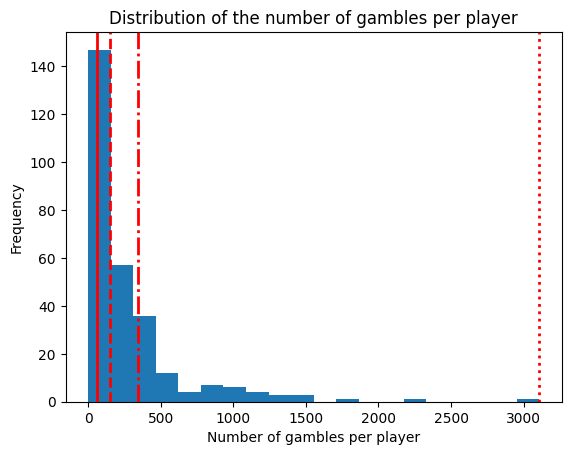

In [25]:
# Plot the distribution of the number of gambles per player
plt.hist(gambles_per_player, bins=20)
# Plot the first quartile as a vertical line
plt.axvline(first_quartile, color='r', linestyle='solid', linewidth=2)
# Plot the second quartile as a vertical line
plt.axvline(second_quartile, color='r', linestyle='dashed', linewidth=2)
# Plot the third quartile as a vertical line
plt.axvline(third_quartile, color='r', linestyle='dashdot', linewidth=2)
# Plot the fourth quartile as a vertical line
plt.axvline(fourth_quartile, color='r', linestyle='dotted', linewidth=2)
plt.xlabel("Number of gambles per player")
plt.ylabel("Frequency")
plt.title("Distribution of the number of gambles per player")
plt.show()


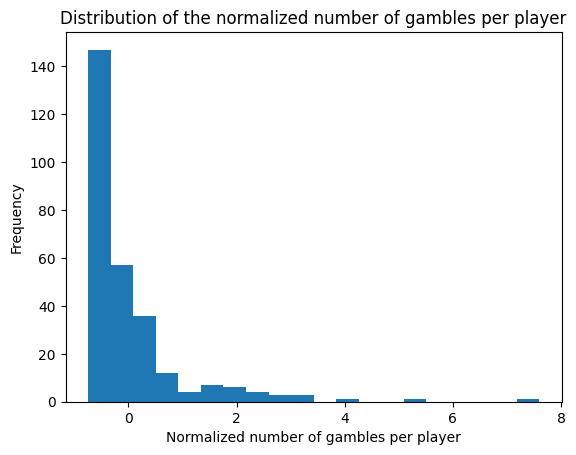

In [16]:
# Normalized the number of gambles per player
gambles_per_player_normalized = (gambles_per_player - np.mean(gambles_per_player)) / np.std(gambles_per_player)

# Plot the distribution of the normalized number of gambles per player
plt.hist(gambles_per_player_normalized, bins=20)
plt.xlabel("Normalized number of gambles per player")
plt.ylabel("Frequency")
plt.title("Distribution of the normalized number of gambles per player")
plt.show()

In [25]:
# Let's create two separarte dataframes for the top 20% and bottom 20% of players by creating a list of player for each percentile
top_20 = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() >= percentile_80].index.tolist()
bottom_20 = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() <= percentile_20].index.tolist()

# How many players are in the top 20%?
print("Number of players in the top 20%:", len(top_20))

# How many players are in the bottom 20%?
print("Number of players in the bottom 20%:", len(bottom_20))

# Create a dataframe for the top 20% of players
dtf_top_20 = dtf[dtf['playerkey'].isin(top_20)]
dtf_top_20['percentile'] = 'top_20'

# Create a dataframe for the bottom 20% of players
dtf_bottom_20 = dtf[dtf['playerkey'].isin(bottom_20)]
dtf_bottom_20['percentile'] = 'bottom_20'

# Concatenate the two dataframes
dtf_20_gambles = pd.concat([dtf_top_20, dtf_bottom_20])

Number of players in the top 20%: 57
Number of players in the bottom 20%: 58


In [26]:
# Let's create two separarte dataframes for the top 10% and bottom 10% of players by creating a list of player for each percentile
top_10 = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() >= percentile_90].index.tolist()
bottom_10 = dtf.groupby("playerkey")["gambles"].max()[dtf.groupby("playerkey")["gambles"].max() <= percentile_10].index.tolist()

# How many players are in the top 10%?
print("Number of players in the top 10%:", len(top_10))

# How many players are in the bottom 10%?
print("Number of players in the bottom 10%:", len(bottom_10))

# Create a dataframe for the top 10% of players
dtf_top_10 = dtf[dtf['playerkey'].isin(top_10)]
dtf_top_10['percentile'] = 'top_10'

# Create a dataframe for the bottom 10% of players
dtf_bottom_10 = dtf[dtf['playerkey'].isin(bottom_10)]
dtf_bottom_10['percentile'] = 'bottom_10'

# Concatenate the two dataframes
dtf_10_gambles = pd.concat([dtf_top_10, dtf_bottom_10])

Number of players in the top 10%: 29
Number of players in the bottom 10%: 29


## Duration

In [27]:
# Calculate the duration per player and store it in a list
duration_per_player = []
for i in dtf["playerkey"].unique().tolist():
    duration_per_player.append(dtf[dtf["playerkey"] == i]["duration"].sum())

# Calculate the 20th percentile of the duration per player and store is as percentile_20_duration
percentile_20_duration = np.percentile(duration_per_player, 20)
print("20th percentile of the duration per player:", percentile_20_duration)

# Calculate the 80th percentile of the duration per player and store is as percentile_80_duration
percentile_80_duration = np.percentile(duration_per_player, 80)
print("80th percentile of the duration per player:", percentile_80_duration)

# Seperation line
print("------------------------------------------------------------------")

# Calculate the 10th percentile of the duration per player and store is as percentile_10_duration
percentile_10_duration = np.percentile(duration_per_player, 10)
print("10th percentile of the duration per player:", percentile_10_duration)

# Calculate the 90th percentile of the duration per player and store is as percentile_90_duration
percentile_90_duration = np.percentile(duration_per_player, 90)
print("90th percentile of the duration per player:", percentile_90_duration)

20th percentile of the duration per player: 0 days 00:03:48.767800
80th percentile of the duration per player: 0 days 00:34:04.384400001
------------------------------------------------------------------
10th percentile of the duration per player: 0 days 00:01:51.008800
90th percentile of the duration per player: 0 days 00:54:35.320600001


In [28]:
# Let's create two separarte dataframes for the top 20% and bottom 20% of players by creating a list of player for each percentile
top_20_duration = dtf.groupby("playerkey")["duration"].sum()[dtf.groupby("playerkey")["duration"].sum() >= percentile_80_duration].index.tolist()
bottom_20_duration = dtf.groupby("playerkey")["duration"].sum()[dtf.groupby("playerkey")["duration"].sum() <= percentile_20_duration].index.tolist()

# How many players are in the top 20%?
print("Number of players in the top 20%:", len(top_20_duration))

# How many players are in the bottom 20%?
print("Number of players in the bottom 20%:", len(bottom_20_duration))

# Create a dataframe for the top 20% of players
dtf_top_20_duration = dtf[dtf['playerkey'].isin(top_20_duration)]
dtf_top_20_duration['percentile'] = 'top_20'

# Create a dataframe for the bottom 20% of players
dtf_bottom_20_duration = dtf[dtf['playerkey'].isin(bottom_20_duration)]
dtf_bottom_20_duration['percentile'] = 'bottom_20'

# Concatenate the two dataframes
dtf_20_duration = pd.concat([dtf_top_20_duration, dtf_bottom_20_duration])

Number of players in the top 20%: 57
Number of players in the bottom 20%: 57


In [29]:
# Let's create two separarte dataframes for the top 10% and bottom 10% of players by creating a list of player for each percentile
top_10_duration = dtf.groupby("playerkey")["duration"].sum()[dtf.groupby("playerkey")["duration"].sum() >= percentile_90_duration].index.tolist()
bottom_10_duration = dtf.groupby("playerkey")["duration"].sum()[dtf.groupby("playerkey")["duration"].sum() <= percentile_10_duration].index.tolist()

# How many players are in the top 10%?
print("Number of players in the top 10%:", len(top_10_duration))

# How many players are in the bottom 10%?
print("Number of players in the bottom 10%:", len(bottom_10_duration))

# Create a dataframe for the top 10% of players
dtf_top_10_duration = dtf[dtf['playerkey'].isin(top_10_duration)]
dtf_top_10_duration['percentile'] = 'top_10'

# Create a dataframe for the bottom 10% of players
dtf_bottom_10_duration = dtf[dtf['playerkey'].isin(bottom_10_duration)]
dtf_bottom_10_duration['percentile'] = 'bottom_10'

# Concatenate the two dataframes
dtf_10_duration = pd.concat([dtf_top_10_duration, dtf_bottom_10_duration])


Number of players in the top 10%: 29
Number of players in the bottom 10%: 29


## Safety Check

In [30]:
# Are the lists top_20_gambles and top_20_duration players the same?
print("Are the lists top_20_gambles and top_20_duration players the same?", top_20 == top_20_duration)
# Which players are in the top 20% of gambles but not in the top 20% of duration?
print("Players in the top 20% of gambles but not in the top 20% of duration:", set(top_20) - set(top_20_duration))

# Seperation line
print("------------------------------------------------------------------")
# Are the lists bottom_20_gambles and bottom_20_duration players the same?
print("Are the lists bottom_20_gambles and bottom_20_duration players the same?", bottom_20 == bottom_20_duration)

# Which players are in the bottom 20% of gambles but not in the bottom 20% of duration?
print("Players in the bottom 20% of gambles but not in the bottom 20% of duration:", set(bottom_20) - set(bottom_20_duration))

# Seperation line
print("------------------------------------------------------------------")
# Are the lists top_10_gambles and top_10_duration players the same?
print("Are the lists top_10_gambles and top_10_duration players the same?", top_10 == top_10_duration)

# Which players are in the top 10% of gambles but not in the top 10% of duration?
print("Players in the top 10% of gambles but not in the top 10% of duration:", set(top_10) - set(top_10_duration))

# Seperation line
print("------------------------------------------------------------------")
# Are the lists bottom_10_gambles and bottom_10_duration players the same?
print("Are the lists bottom_10_gambles and bottom_10_duration players the same?", bottom_10 == bottom_10_duration)

# Which players are in the bottom 10% of gambles but not in the bottom 10% of duration?
print("Players in the bottom 10% of gambles but not in the bottom 10% of duration:", set(bottom_10) - set(bottom_10_duration))


Are the lists top_20_gambles and top_20_duration players the same? False
Players in the top 20% of gambles but not in the top 20% of duration: {224, 6, 238, 529, 20, 507, 92, 94}
------------------------------------------------------------------
Are the lists bottom_20_gambles and bottom_20_duration players the same? False
Players in the bottom 20% of gambles but not in the bottom 20% of duration: {230, 13, 274, 147, 149, 219}
------------------------------------------------------------------
Are the lists top_10_gambles and top_10_duration players the same? False
Players in the top 10% of gambles but not in the top 10% of duration: {194, 196, 23, 135}
------------------------------------------------------------------
Are the lists bottom_10_gambles and bottom_10_duration players the same? False
Players in the bottom 10% of gambles but not in the bottom 10% of duration: {67, 485, 390, 230, 176, 506, 314, 476}


# Save Dataframes

In [31]:
# Define saving path
path = "/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/2_June"
os.chdir(path)

# General Dataframe to parquet
dtf.to_parquet("General.parquet")

# Save the dataframes for the top 20% and bottom 20% of players
dtf_20_gambles.to_parquet("Combine_20_gambles.parquet")
dtf_20_duration.to_parquet("Combine_20_duration.parquet")

# Save the dataframes for the top 10% and bottom 10% of players
dtf_10_gambles.to_parquet("Combine_10_gambles.parquet")
dtf_10_duration.to_parquet("Combine_10_duration.parquet")

# Save bottom 20% of players
dtf_bottom_20_duration.to_parquet("Bottom_20_duration.parquet")

# Save top 20% of players
dtf_top_20_duration.to_parquet("Top_20_duration.parquet")

# Save bottom 10% of players
dtf_bottom_10_duration.to_parquet("Bottom_10_duration.parquet")

# Save top 10% of players
dtf_top_10_duration.to_parquet("Top_10_duration.parquet")

# Save bottom 20% of players
dtf_bottom_20.to_parquet("Bottom_20_gambles.parquet")

# Save top 20% of players
dtf_top_20.to_parquet("Top_20_gambles.parquet")

# Save bottom 10% of players
dtf_bottom_10.to_parquet("Bottom_10_gambles.parquet")

# Save top 10% of players
dtf_top_10.to_parquet("Top_10_gambles.parquet")
